<a href="https://colab.research.google.com/github/gitSean23/LandSatClassification/blob/main/CNNSat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%tensorflow_version 2.x

In [3]:
!pip install pyyaml h5py

In [4]:
!pip install -q tensorflow-datasets tensorflow

In [5]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [6]:
(tf_train, tf_val, tf_test), info = tfds.load('eurosat', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], shuffle_files=True, as_supervised=True, with_info=True)
classes = info.features['label'].num_classes
labels = info.features['label']
features = ['Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'AnnualCrop']
labelList = []
imgList = []

test_labels = []
test_imgs = []
for i, j in tf_train:
  labelList.append(j)
  imgList.append(i)

for k,z in tf_test:
  test_imgs.append(k)
  test_labels.append(z)
print(labelList[3].numpy())
print(imgList[3])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete44WE31/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
7
tf.Tensor(
[[[ 56  85  91]
  [ 56  85  89]
  [ 60  88  92]
  ...
  [ 75  93  97]
  [ 76  94  98]
  [ 74  93  97]]

 [[ 56  85  91]
  [ 56  85  89]
  [ 59  87  91]
  ...
  [ 76  91  96]
  [ 74  92  96]
  [ 73  92  96]]

 [[ 47  76  80]
  [ 47  76  80]
  [ 50  77  84]
  ...
  [ 76  91  94]
  [ 76  91  96]
  [ 74  91  98]]

 ...

 [[ 57  88  90]
  [ 57  87  89]
  [ 60  90  90]
  ...
  [ 80  99 105]
  [ 72  91  98]
  [ 74  94 103]]

 [[ 65  95  95]
  [ 65  95  95]
  [ 66  94  95]
  ...
  [ 74  93  97]
  [ 68  87  93]
  [ 81 100 107]]

 [[ 66  96  96]
  [ 66  96  96]
  [ 73  99 100]
  ...
  [ 67  88  91]
  [ 70  87  94]
  [ 70  87  94]]], shape=(64, 64, 3), dtype=uint8)


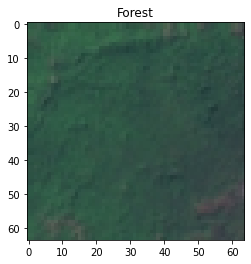

In [13]:
x = plt.imshow(imgList[19])
y = plt.title(features[labelList[19].numpy()-1])

In [25]:
def normalize_img(image, label):
  #Turns the imgs from uint8 values to pixel float32 values
  return tf.cast(image, tf.float32) / 255., label

In [26]:
dA = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)])

In [27]:
daImg = imgList[0]

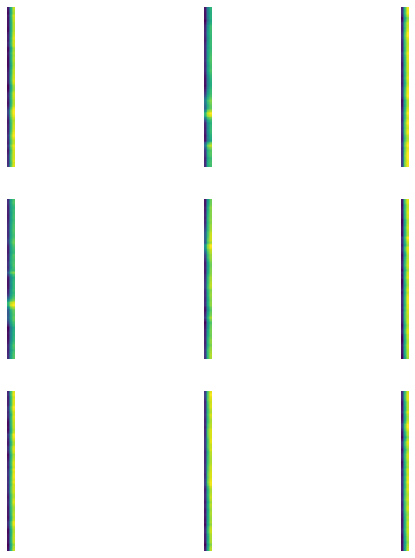

In [28]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = dA(daImg)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [29]:
tf_train = tf_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_train = tf_train.cache()
tf_train = tf_train.shuffle(info.splits['train'].num_examples)
tf_train = tf_train.batch(64)
tf_train = tf_train.prefetch(tf.data.experimental.AUTOTUNE)

In [30]:
tf_test = tf_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_test = tf_test.batch(64)
tf_test = tf_test.cache()
tf_test = tf_test.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [32]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32,(4,4), input_shape=(64,64,3)))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (4,4)))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (4,4)))
model.add(layers.LeakyReLU(alpha=0.3))

In [33]:
model.add(layers.Flatten())
model.add(layers.Dense(32,input_dim=64))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(10, activation='softmax')) #10 classes

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 32)        1568      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        32832     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 27, 27, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

In [36]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(tf_train, epochs=15, batch_size=64, callbacks=[callback], verbose=2)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


338/338 - 37s - loss: 1.1936 - accuracy: 0.5469
Epoch 2/15
338/338 - 5s - loss: 0.7905 - accuracy: 0.7113
Epoch 3/15
338/338 - 5s - loss: 0.6971 - accuracy: 0.7507
Epoch 4/15
338/338 - 5s - loss: 0.6045 - accuracy: 0.7838
Epoch 5/15
338/338 - 5s - loss: 0.5373 - accuracy: 0.8081
Epoch 6/15
338/338 - 5s - loss: 0.5006 - accuracy: 0.8231
Epoch 7/15
338/338 - 5s - loss: 0.4666 - accuracy: 0.8365
Epoch 8/15
338/338 - 5s - loss: 0.4172 - accuracy: 0.8544
Epoch 9/15
338/338 - 5s - loss: 0.3855 - accuracy: 0.8661
Epoch 10/15
338/338 - 5s - loss: 0.3583 - accuracy: 0.8738
Epoch 11/15
338/338 - 5s - loss: 0.3358 - accuracy: 0.8822
Epoch 12/15
338/338 - 5s - loss: 0.3061 - accuracy: 0.8911
Epoch 13/15
338/338 - 5s - loss: 0.2652 - accuracy: 0.9070
Epoch 14/15
338/338 - 5s - loss: 0.2437 - accuracy: 0.9123
Epoch 15/15
338/338 - 5s - loss: 0.2219 - accuracy: 0.9205


In [37]:
model.evaluate(tf_test, batch_size=64, verbose=1)

 1/43 [..............................] - ETA: 12s - loss: 1.1804 - accuracy: 0.7500

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


43/43 [==============================] - 1s 23ms/step - loss: 0.7112 - accuracy: 0.7970


[0.7111700177192688, 0.7970370650291443]

In [38]:
model.save('euro.h5')

In [39]:
euroModel = keras.models.load_model('euro.h5')

In [40]:
def classify():
  if feature_predict == "Pasture" or feature_predict == "AnnualCrop" or feature_predict == "PermanentCrop" or feature_predict == "HerbaceousVegetation":
    print("Safe")
  else:
    print("Unsafe")

[1.3968963e-03 1.3144372e-10 7.8641679e-06 2.0983236e-07 8.3688712e-14
 1.7999422e-07 2.2762929e-09 7.7888031e-16 6.2114414e-06 9.9858862e-01]
9
Predicted: SeaLake
Expected: SeaLake
Unsafe


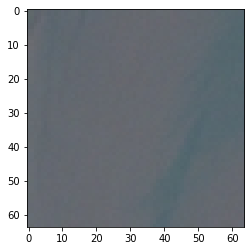

In [54]:
target = 91
prediction = model.predict(tf_test)
print(prediction[target])
#y = np.amax(prediction[target])*10
#y = int(y)
#print(y)
feature_predict = features[np.argmax(prediction[target])-1]
#print(prediction[target][y])
print("Predicted:", feature_predict)
print("Expected:", features[test_labels[target].numpy()-1])
plt.imshow(test_imgs[target])
classify()